# President elections 2012 and 2018 in Moscow

### ...using non-negative constrained multivariate regression

In [1]:
# Load libraries and set up notebook

%matplotlib notebook

import numpy as np
import pylab as plt
import seaborn as sns; sns.set()
import pandas as pd
from zipfile import ZipFile
import scipy

import matplotlib as mpl
mpl.rcParams.update({'nbagg.transparent': False, 'figure.facecolor': 'white'})

In [275]:
def loaddata(year):
    zip_file = ZipFile('electionsData.zip')
    
    table = pd.read_csv(zip_file.open('{}.txt'.format(year)), sep='\t')
        
    colFilter = ['ПУТИН', 'Путин', 'Единая Россия', 'ЕДИНАЯ РОССИЯ', 'Медведев']
    col = [col for col in table.columns if any([f in col for f in colFilter])]
    leader = np.squeeze(table[col].values)
    
    colFilter = ['Число избирателей, включенных', 'Число избирателей, внесенных']
    col = [col for col in table.columns if any([f in col for f in colFilter])]
    voters = np.squeeze(table[col].values)
    
    colFilter = ['бюллетеней, выданных']                # should select 3 columns
    col = [col for col in table.columns if any([f in col for f in colFilter])]
    given = np.sum(table[col].values, axis=1)

    colFilter = ['действительных', 'недействительных']  # should select 2 columns
    excludeFilter = ['отметок']  # excludes one additional column in the 2000 data
    col = [col for col in table.columns if any([f in col for f in colFilter]) and 
                                           all([f not in col for f in excludeFilter])]
    received = np.sum(table[col].values, axis=1)
    
    colFilter = ['Собчак', 'Явлинский', 'Титов', 'Прохоров', 'ПАРНАС', 'ЯБЛОКО']   
    col = [col for col in table.columns if any([f in col for f in colFilter])]
    liberals = np.sum(table[col].values, axis=1)
    
    regions = table['region'].values
    tiks = table['tik'].values
    
    return (voters, given, received, leader, liberals, regions, tiks)

In [488]:
# Load TIK data

years = [2012, 2016, 2018]
selectedtiks = {}
tikdata = {}

# tikmask = ['Екатеринбург,', 'Красноярск,', 'Пермь,', 'Омск,', 'Новосибирск,']

for year in years:
    voters, given, received, leader, liberals, regions, tiks = loaddata(year)
    data = np.concatenate((voters[:,None]-given[:,None], leader[:,None], liberals[:,None], 
                           given[:,None]-leader[:,None]-liberals[:,None]), axis=1)

    selectedtiks[year] = np.unique(tiks[['Москва' in r for r in regions]])
#     selectedtiks[year] = np.unique(tiks[[any([tt in t for tt in tikmask]) for t in tiks]])
    
    tikdata[year] = np.zeros((selectedtiks[year].size, data.shape[1]))
    for i,t in enumerate(selectedtiks[year]):
        tikdata[year][i,:] = np.sum(data[tiks==t,:], axis=0)
    tikdata[year] = tikdata[year] / np.sum(tikdata[year],axis=1,keepdims=True)
    
for y in selectedtiks:
    selectedtiks[y] = np.array([' '.join(t.split()[1:]) for t in selectedtiks[y]])

In [489]:
# Select TIKs that stayed the same

commontiks = np.intersect1d(selectedtiks[2012], selectedtiks[2018])
commontiks = np.intersect1d(commontiks, selectedtiks[2016])

for year in tikdata:
    tikdata[year] = tikdata[year][[np.where(selectedtiks[year]==t)[0][0] for t in commontiks], :]

print(commontiks.size)
print(commontiks)

125
['Академический район' 'Алексеевский район' 'Алтуфьевский район'
 'Бабушкинский район' 'Басманный район' 'Бескудниковский район'
 'Бутырский район' 'Войковский район' 'Гагаринский район'
 'Головинский район' 'Даниловский район' 'Дмитровский район'
 'Донской район' 'Красносельский район' 'Левобережный район'
 'Ломоносовский район' 'Лосиноостровский район' 'Мещанский район'
 'Можайский район' 'Молжаниновский район' 'Нагорный район'
 'Нижегородский район' 'Обручевский район' 'Останкинский район'
 'Пресненский район' 'Рязанский район' 'Савеловский район'
 'Таганский район' 'Тверской район' 'Тимирязевский район'
 'Хорошевский район' 'Южнопортовый район' 'Ярославский район' 'район Арбат'
 'район Аэропорт' 'район Беговой' 'район Бибирево'
 'район Бирюлево Восточное' 'район Бирюлево Западное' 'район Богородское'
 'район Братеево' 'район Вешняки' 'район Внуково'
 'район Восточное Дегунино' 'район Восточное Измайлово' 'район Восточный'
 'район Выхино-Жулебино' 'район Гольяново' 'район Дорого

<IPython.core.display.Javascript object>


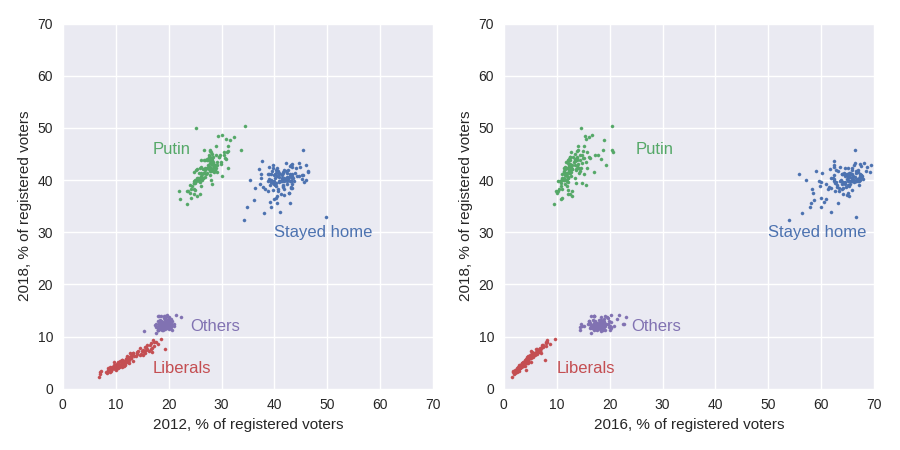

In [477]:
# Plot 

plt.figure(figsize=(9,4.5))

plt.subplot(121)
for i in range(4):
    plt.scatter(100*tikdata[2012][:,i], 100*tikdata[2018][:,i], s=5)
plt.xlabel('2012, % of registered voters')
plt.ylabel('2018, % of registered voters')
plt.xlim([0,70])
plt.ylim([0,70])
plt.gca().set_prop_cycle(None)
plt.text(40, 29, 'Stayed home', color=next(plt.gca()._get_lines.prop_cycler)['color'])
plt.text(17, 45, 'Putin',       color=next(plt.gca()._get_lines.prop_cycler)['color'])
plt.text(17, 3,  'Liberals',    color=next(plt.gca()._get_lines.prop_cycler)['color'])
plt.text(24, 11, 'Others',      color=next(plt.gca()._get_lines.prop_cycler)['color'])

plt.subplot(122)
for i in range(4):
    plt.scatter(100*tikdata[2016][:,i], 100*tikdata[2018][:,i], s=5)
plt.xlabel('2016, % of registered voters')
plt.ylabel('2018, % of registered voters')
plt.xlim([0,70])
plt.ylim([0,70])
plt.gca().set_prop_cycle(None)
plt.text(50, 29, 'Stayed home', color=next(plt.gca()._get_lines.prop_cycler)['color'])
plt.text(25, 45, 'Putin',       color=next(plt.gca()._get_lines.prop_cycler)['color'])
plt.text(10, 3,  'Liberals',    color=next(plt.gca()._get_lines.prop_cycler)['color'])
plt.text(24, 11, 'Others',      color=next(plt.gca()._get_lines.prop_cycler)['color'])
plt.tight_layout()

plt.tight_layout()

In [483]:
x = tikdata[2012]
y = tikdata[2018]

# # OLS regression. Sums to 1 but not non-negative
beta = np.linalg.inv(x.T @ x) @ x.T @ y

print(beta)

# # Non-negative regression. Does not sum to 1
betann = np.zeros_like(beta)
for i in range(4):
    betann[:,i] = scipy.optimize.nnls(x, y[:,i])[0]

# Non-negative constrained regression
def myfit(x,y):
    beta = np.linalg.inv(x.T @ x) @ y.T @ y

    betann = np.zeros((4,4))
    for i in range(4):
        betann[:,i] = scipy.optimize.nnls(x, y[:,i])[0]

    residual = lambda beta: np.sum((y - x @ beta.reshape(4,4))**2)
    bnds = ((0, None), (0, None), (0, None), (0, None), 
            (0, None), (0, None), (0, None), (0, None), 
            (0, None), (0, None), (0, None), (0, None), 
            (0, None), (0, None), (0, None), (0, None))
    cons = ({'type': 'eq', 'fun': lambda beta: np.sum(beta[:4])-1},
            {'type': 'eq', 'fun': lambda beta: np.sum(beta[4:8])-1},
            {'type': 'eq', 'fun': lambda beta: np.sum(beta[8:12])-1},
            {'type': 'eq', 'fun': lambda beta: np.sum(beta[12:])-1})
    b = scipy.optimize.minimize(residual, betann.flatten(), method='SLSQP', bounds=bnds, constraints=cons)
    b = b['x'].reshape(4,4)
    b[b<1e-6] = 0
    return b

betannc = myfit(x,y)
print(' ')
print(betannc)

[[ 0.65123748  0.26223638 -0.00430616  0.0908323 ]
 [ 0.08742458  0.8935938  -0.07251451  0.09149613]
 [ 0.63590376 -0.15972455  0.51406953  0.00975126]
 [ 0.14977667  0.46590733  0.07589802  0.30841798]]
 
[[ 0.64703164  0.26383514  0.          0.08913323]
 [ 0.          0.95464691  0.          0.04535309]
 [ 0.54248755  0.          0.45751245  0.        ]
 [ 0.34190895  0.2743537   0.          0.38373735]]


In [485]:
# Bootstrapping to get standard errors

nrep = 100
bootstrap = np.zeros((4,4,100))
for i in range(nrep):
    print('.', end='')
    ind = np.random.choice(x.shape[0], x.shape[0])
    bootstrap[:,:,i] = myfit(x[ind,:], y[ind,:])
    
err = np.std(bootstrap, axis=2)

....................................................................................................

In [486]:
# Formatted output

vars = ['Home', 'Putin', 'Liberals', 'Others']
print('\t\t', end='')
print('\t'.join([c+'-2018' for c in vars]))
print('')
for i in range(4):
    print(vars[i]+'-2012\t', end='')
    for j in range(4):
        print('{:04.1f}% ± {:1.1f}%'.format(100*betannc[i,j], 100*err[i,j]), end='\t')
    print('')

		Home-2018	Putin-2018	Liberals-2018	Others-2018

Home-2012	64.7% ± 6.0%	26.4% ± 5.3%	00.0% ± 0.0%	08.9% ± 1.7%	
Putin-2012	00.0% ± 3.8%	95.5% ± 4.5%	00.0% ± 0.0%	04.5% ± 2.5%	
Liberals-2012	54.2% ± 1.4%	00.0% ± 0.1%	45.8% ± 1.0%	00.0% ± 0.8%	
Others-2012	34.2% ± 10.4%	27.4% ± 9.2%	00.0% ± 0.5%	38.4% ± 4.7%	


In [484]:
# https://lyubarev.livejournal.com/39505.html compares 2016 and 2018

b = myfit(tikdata[2016], tikdata[2018])
print(b)

[[ 0.58256854  0.3072989   0.01204907  0.09808349]
 [ 0.          0.90308836  0.          0.09691164]
 [ 0.52211146  0.          0.47788854  0.        ]
 [ 0.00740173  0.5888413   0.14225031  0.26150666]]
